# CE7454 Project: Movie Rateing and Box-office Prediction

*Group 26: Li Jie, Shen Meng, Wang Ruihang*

Welcome to the our project! In this work, we are going to save the viewers and producers from the ocean of movies. Our job is to give a reliable prediction of a movies's rating and box-office before its theatrical release, aiming to offer useful information in an early stage. 

**In this project, we will:**
- Crawl and build our dataset from [IMDB](https://www.imdb.com)
- Clean and present the raw data for analysis
- Apply different models for movie rating and box-office prediction
- Propose our new architecture for further improvement
- Compare and analyze the results of each method

<table>

<img src="images/posters.png" style="width:800;height:300px;">

</table>

Run the following cell to load the packages and dependencies that are going to be useful for our project.

In [1]:
import os
import requests
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from torch.utils import data
from torchvision import transforms, utils
from torch.utils.data import Dataset, DataLoader
from PIL import Image

%matplotlib inline

**Note**: We use the open source deep learning library [Pytorch](https://pytorch.org) to build our models

## 1 - Web Scraping for Dataset

## 2 - Preprocessing and Visualization

In this section, we investigate the impact of different variables on movie rating and box-office revenues. The data we crawled from Internet contains list of movie's information, such as budget, duration, genres, actors, directors, writers, story line, poster and its corresponding rating and box-office. Through preprocessing, the variables can be categorized as three types: *numerical data, vector data and image data*

- **Budget**: Budget is a numerical number that represents the financial investment in a movie
- **Duration**: Duration is a numerical number that defines the running time of a movie
- **Year**: Year is a numerical number that reveals the production time
- **Genres**: Movie genre is vector data with corresponding position set to one for a movie belongs to and others to zeros
- **Story line**: Story line is a word vector data that contains brief introduction of the movie
- **Poster**: Movie poster is a image data that contains potential information to exploit

In [47]:
imdb = pd.read_csv('../data/imdb.tsv', sep='\t')
imdb['Ratio'] = imdb['Box_Office'] / (imdb['Budget'] + 1)
imdb = imdb.drop(imdb[(imdb['Ratio']>10) | (imdb['Budget'] < 10000) | (imdb['Ratio']<0.05)].index)
imdb.describe()

,Budget,Box_Office,Year,Run_Time,Average_Rating,Num_Voters,Ratio
count,6.567000e+03,6.567000e+03,6567.000000,6567.000000,6567.000000,6.567000e+03,6567.000000
mean,2.331077e+07,5.699841e+07,2009.421349,105.492005,6.184316,5.698153e+04,1.650018
std,3.761012e+07,1.406144e+08,5.011153,17.941605,1.084342,1.256721e+05,1.896471
min,1.000000e+04,5.810000e+02,2000.000000,60.000000,1.100000,5.000000e+00,0.050021
25%,2.000000e+06,8.021520e+05,2006.000000,93.000000,5.600000,1.099000e+03,0.274666
50%,8.000000e+06,5.758522e+06,2009.000000,102.000000,6.300000,8.962000e+03,0.922471
75%,2.700000e+07,4.454230e+07,2014.000000,115.000000,6.900000,5.479400e+04,2.332574
max,3.210000e+08,2.048360e+09,2018.000000,180.000000,9.400000,2.111245e+06,9.985523


We can see that 48.104 percent of movies are profitable.

percentage of profitable movies: 48.104


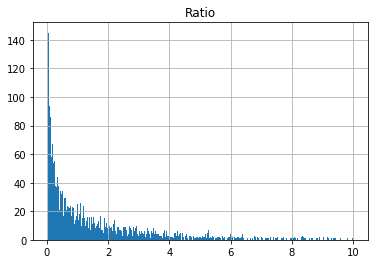

In [50]:
print("percentage of profitable movies: %0.3f" % float((imdb['Ratio']>1).sum() / len(imdb) * 100))
imdb.hist(column="Ratio",bins=1000)
plt.show()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12a3d49d0>]],
      dtype=object)

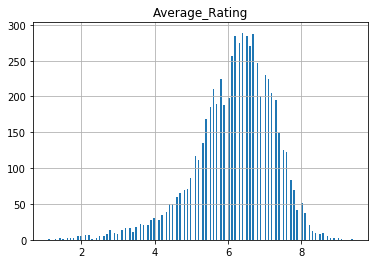

In [51]:
imdb.hist(column="Average_Rating",bins=200)

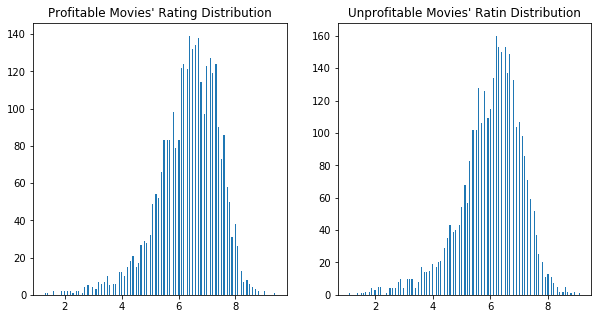

In [52]:
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.hist(imdb[imdb['Ratio']>1]['Average_Rating'].to_numpy(),bins=(200))
plt.title("Profitable Movies' Rating Distribution")
plt.subplot(122)
plt.hist(imdb[imdb['Ratio']<1]['Average_Rating'].to_numpy(), bins = 200)
plt.title("Unprofitable Movies' Ratin Distribution")
plt.show()

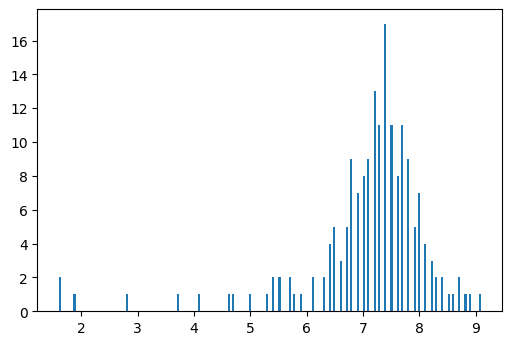

In [71]:
plt.figure(dpi=100)
plt.hist(imdb[imdb['Genre'].str.contains("Documentary")]['Average_Rating'].to_numpy(), bins = 200)
plt.show()

<Figure size 600x400 with 0 Axes>

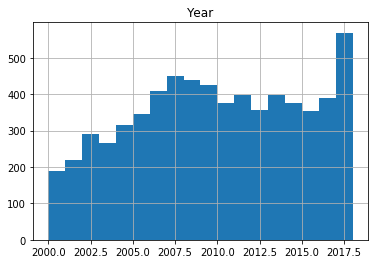

In [75]:
plt.figure(dpi=100)
imdb.hist(column='Year',bins=18)
plt.show()

In [85]:
for year in range(2000,2019):
    rating = imdb[imdb['Year'] == year]['Average_Rating'].sum() 
    movie_num = (imdb['Year'] == year).sum()
    rating /= movie_num
    print("Year: %d Average Rating: %.3f movie_num: %d" % (year, rating, movie_num))

Year: 2000 Average Rating: 6.221 movie_num: 189
Year: 2001 Average Rating: 6.263 movie_num: 220
Year: 2002 Average Rating: 6.182 movie_num: 291
Year: 2003 Average Rating: 6.191 movie_num: 265
Year: 2004 Average Rating: 6.185 movie_num: 316
Year: 2005 Average Rating: 6.185 movie_num: 345
Year: 2006 Average Rating: 6.236 movie_num: 408
Year: 2007 Average Rating: 6.180 movie_num: 450
Year: 2008 Average Rating: 6.188 movie_num: 439
Year: 2009 Average Rating: 6.182 movie_num: 424
Year: 2010 Average Rating: 6.217 movie_num: 377
Year: 2011 Average Rating: 6.038 movie_num: 398
Year: 2012 Average Rating: 6.107 movie_num: 357
Year: 2013 Average Rating: 6.209 movie_num: 399
Year: 2014 Average Rating: 6.155 movie_num: 377
Year: 2015 Average Rating: 6.189 movie_num: 354
Year: 2016 Average Rating: 6.163 movie_num: 389
Year: 2017 Average Rating: 6.257 movie_num: 315
Year: 2018 Average Rating: 6.237 movie_num: 254


Run_time: 60 Average Rating: 6.933 movie_num: 6
Run_time: 65 Average Rating: 6.550 movie_num: 8
Run_time: 70 Average Rating: 5.809 movie_num: 35
Run_time: 75 Average Rating: 5.881 movie_num: 96
Run_time: 80 Average Rating: 5.718 movie_num: 298
Run_time: 85 Average Rating: 5.702 movie_num: 587
Run_time: 90 Average Rating: 5.825 movie_num: 911
Run_time: 95 Average Rating: 6.004 movie_num: 901
Run_time: 100 Average Rating: 6.127 movie_num: 812
Run_time: 105 Average Rating: 6.251 movie_num: 665
Run_time: 110 Average Rating: 6.360 movie_num: 539
Run_time: 115 Average Rating: 6.553 movie_num: 438
Run_time: 120 Average Rating: 6.571 movie_num: 352
Run_time: 125 Average Rating: 6.693 movie_num: 236
Run_time: 130 Average Rating: 6.910 movie_num: 196
Run_time: 135 Average Rating: 6.654 movie_num: 134
Run_time: 140 Average Rating: 6.902 movie_num: 112
Run_time: 145 Average Rating: 6.843 movie_num: 61
Run_time: 150 Average Rating: 6.725 movie_num: 55
Run_time: 155 Average Rating: 6.836 movie_num: 

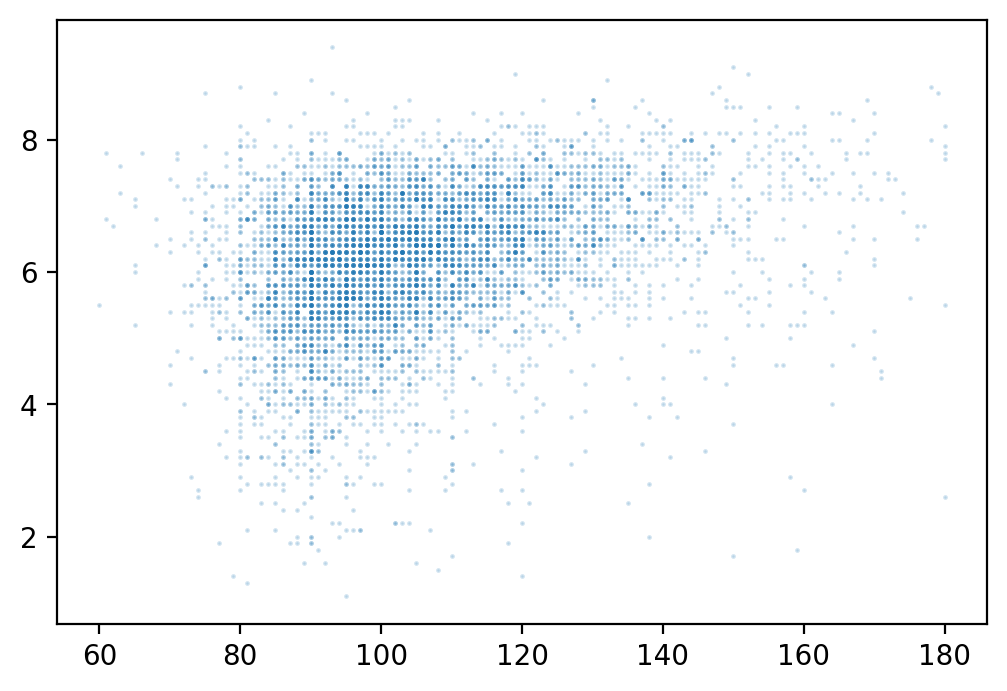

In [121]:
for run_time in range(60,181,5):
    rating = imdb[(imdb['Run_Time'] >= run_time) & (imdb['Run_Time'] < run_time+5)]['Average_Rating'].sum() 
    movie_num = ((imdb['Run_Time'] >= run_time) & (imdb['Run_Time'] < run_time+5)).sum()
    rating /= movie_num
    print("Run_time: %d Average Rating: %.3f movie_num: %d" % (run_time, rating, movie_num))
plt.figure(dpi=200)   
plt.scatter(imdb['Run_Time'].to_numpy(), imdb['Average_Rating'].to_numpy(), s=0.5,alpha=0.2)

## 3 - Baseline Models

## 4 - Proposed Solutions

## 5 - Results Analysis